In [13]:
#importing libraries
import pandas as pd

import yfinance as yf
import requests
from bs4 import BeautifulSoup

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [14]:
# Using the Ticker function to create a ticker object.
# ticker symbol of tesla is GOOGL for example
stock_data = yf.Ticker('TSLA')

# history function helps to extract stock information.
# setting period parameter to max to get information for the maximum amount of time.
stock_data = stock_data.history(period='max')

# Resetting the index
stock_data.reset_index(inplace=True)
stock_data = stock_data.iloc[:, :-2]
stock_data['Amount'] = (stock_data['High'] + stock_data['Low']) * stock_data['Volume'] / 2
# display the first five rows
stock_data.head()

,Date,Open,High,Low,Close,Volume,Amount
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,3.991592e+08
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,4.616455e+08
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,1.898132e+08
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,1.074475e+08
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,1.230205e+08


In [15]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
# Training and Testing Data Split into 80:20 ratio
dataset_train = stock_data.head(int(0.8*len(stock_data)))
# '.values' need the 2nd Column Opening Price as a Numpy array (not vector)
# '1:2' is used because the upper bound is ignored
training_set = dataset_train.iloc[:, 1:2].values

# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Show the dataset we're working with
display(dataset_train)

,Date,Open,High,Low,Close,Volume,Amount
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,3.991592e+08
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,4.616455e+08
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,1.898132e+08
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,1.074475e+08
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,1.230205e+08
...,...,...,...,...,...,...,...
2583,2020-10-01 00:00:00-04:00,146.919998,149.626663,144.806671,149.386673,152224500,2.240998e+10
2584,2020-10-02 00:00:00-04:00,140.463333,146.376663,138.333328,138.363327,214290000,3.050525e+10
2585,2020-10-05 00:00:00-04:00,141.116669,144.546661,139.776672,141.893326,134168400,1.907360e+10
2586,2020-10-06 00:00:00-04:00,141.263336,142.926666,135.350006,137.993332,147438900,2.051440e+10


In [16]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras

# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 1))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
history = regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)


Epoch 1/20
79/79 [==============================] - 15s 99ms/step - loss: 0.0022
Epoch 2/20
79/79 [==============================] - 9s 110ms/step - loss: 0.0014
Epoch 3/20
79/79 [==============================] - 9s 109ms/step - loss: 9.9808e-04
Epoch 4/20
79/79 [==============================] - 8s 96ms/step - loss: 9.4328e-04
Epoch 5/20
79/79 [==============================] - 9s 111ms/step - loss: 9.4975e-04
Epoch 6/20
79/79 [==============================] - 9s 117ms/step - loss: 8.5186e-04
Epoch 7/20
79/79 [==============================] - 8s 95ms/step - loss: 9.5626e-04
Epoch 8/20
79/79 [==============================] - 9s 109ms/step - loss: 8.9344e-04
Epoch 9/20
79/79 [==============================] - 9s 110ms/step - loss: 8.4406e-04
Epoch 10/20
79/79 [==============================] - 9s 120ms/step - loss: 7.9982e-04
Epoch 11/20
79/79 [==============================] - 9s 110ms/step - loss: 7.1502e-04
Epoch 12/20
79/79 [==============================] - 10s 124ms/step - los

19/19 [==============================] - 2s 35ms/step


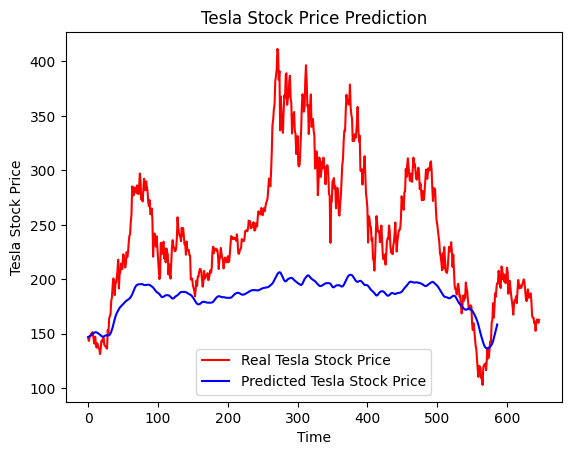

In [17]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price 
# Training and Testing Data Split into 80:20 ratio
dataset_test = stock_data.tail(int(0.2*len(stock_data)))
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
# We need 60 previous inputs for each day of the Test_set in 2017
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs = inputs.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs = sc.transform(inputs)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [20]:
import numpy as np
import pandas as pd

# Load historical data
df = dataset_test[60:].copy()

# Convert 'Close' column to numeric values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Compute rolling averages for 20 and 50 days
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Compute signal for crossover
df['Signal'] = 0
df.loc[df['SMA20'] > df['SMA50'], 'Signal'] = 1
df.loc[df['SMA20'] < df['SMA50'], 'Signal'] = -1

# Calculate returns based on actual prices
df['ActualReturns'] = df['Close'].pct_change()

# Calculate returns based on predicted prices

predicted_prices = predicted_stock_price.flatten() # 20x1 numpy array of predicted prices
nan_indices = np.isnan(predicted_prices)
if np.any(nan_indices):
    predicted_prices = predicted_prices[~nan_indices]
actual_prices = real_stock_price[60:] # 20x1 numpy array of actual prices

predicted_returns = pd.Series(predicted_prices).pct_change()
predicted_returns.index = df.index
df['PredictedReturns'] = predicted_returns

# Compute strategy returns based on predicted prices
df['StrategyReturns'] = df['PredictedReturns'] * df['Signal'].shift(1)

# Compute cumulative returns
df['CumulativeActualReturns'] = (1 + df['ActualReturns']).cumprod() - 1
df['CumulativeStrategyReturns'] = (1 + df['StrategyReturns']).cumprod() - 1

# Compute Sharpe ratio
actual_returns = df['ActualReturns'].mean() / df['ActualReturns'].std() * np.sqrt(252)
strategy_returns = df['StrategyReturns'].mean() / df['StrategyReturns'].std() * np.sqrt(252)

# Print cumulative returns and Sharpe ratio
print('Cumulative returns for buy-and-hold strategy: {:.2f}%'.format(df['CumulativeActualReturns'].iloc[-1] * 100))
print('Cumulative returns for predicted prices strategy: {:.2f}%'.format(df['CumulativeStrategyReturns'].iloc[-1] * 100))
print('Sharpe ratio for buy-and-hold strategy: {:.2f}'.format(actual_returns))
print('Sharpe ratio for predicted prices strategy: {:.2f}'.format(strategy_returns))

Cumulative returns for buy-and-hold strategy: -34.21
Cumulative returns for predicted prices strategy: 4.53
Sharpe ratio for buy-and-hold strategy: 0.02
Sharpe ratio for predicted prices strategy: 0.76
